# Load

In [3]:
# import packages
import os
import cv2
import numpy as np;
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import torch 
import torch.nn as nn
import torchvision.transforms.functional as TF
import segmentation_models_pytorch as smp
import albumentations as album
import math

from sklearn import model_selection
from scipy import ndimage
from typing import Tuple, List
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import Tensor
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Sigmoid
from torch.nn import Module
from torch.optim import SGD
from torch.nn import BCELoss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
import joblib
import time

# Set seed (for reproducibility)
# num = 0
# torch.manual_seed(num)
# random.seed(num)
# np.random.seed(num)

class neural_network(nn.Module):
    """Neural network with LSTM layer and fully connected layer"""
    def __init__(self):
        super(neural_network,self).__init__()
        self.lstm = nn.LSTM(input_size=1, 
                            hidden_size=5,
                            num_layers=1,
                            batch_first=True
                            )
        self.fc1 = nn.Linear(in_features=5,
                             out_features=1)

    def forward(self,x):
        output,_status = self.lstm(x)
        output = output[:,-1,:]
        output = self.fc1(torch.relu(output))
        return output

class CaImagesDataset(Dataset):
    """CA Images dataset."""
    # load the dataset
    def __init__(self, x, y):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)

    # number of samples in the dataset
    def __len__(self):
        return len(self.x)
    
    # get a sample from the dataset
    def __getitem__(self, idx):
        return [self.x[idx], self.y[idx]]

def get_blobs_adaptive(img, bound_size, min_brightness_const, min_area):
    im_gauss = cv2.GaussianBlur(img, (5, 5), 0) # "smoothing" the image with Gaussian Blur
    thresh = cv2.adaptiveThreshold(im_gauss,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,bound_size,(min_brightness_const))
    # Find contours
    cont, hierarchy = cv2.findContours(thresh, 
                            cv2.RETR_EXTERNAL, 
                            cv2.CHAIN_APPROX_SIMPLE # only stores necessary points to define contour (avoids redundancy, saves memory)
                            )
    cont_filtered = []
    for con in cont: 
        area = cv2.contourArea(con) # calculate area, filter for contours above certain size
        if area>min_area: # chosen by trial/error
            cont_filtered.append(con)    
    
    # Draw + fill contours
    new_img = np.full_like(img, 0) # image has black background
    for c in cont_filtered:
        cv2.drawContours(new_img, # image to draw on
                        [c], # contours to draw
                        -1, # contouridx: since negative, all contours are drawn
                        255, # colour of contours: white
                        -1 # thickness: since negative, fill in the shape
                        )
    return new_img, cont_filtered
  
def scale_data_scaler(data, opt):
  """Scales data with MinMaxScaler or StandardScaler
  data: list of data to scale
  opt: "minmax" or "stand" 
  
  Returns scaler and scaled data"""
  if (opt == "minmax"):
    print("minmax")
    scaler = MinMaxScaler(feature_range=(0,1))
    norm_data = [ lst[0] for lst in scaler.fit_transform(np.array(data).reshape((-1, 1)))]
  elif (opt == "stand"):
    print("stand")
    scaler = StandardScaler()
    norm_data = [ lst[0] for lst in scaler.fit_transform(np.array(data).reshape((-1, 1)))]
  return scaler, norm_data

def scale_data(data, full:int):
  """Scales data with image dimensions
  data: list of data to scale
  full: image dimension (height or width)
  
  Returns scaled data"""
  norm_data = [i/full for i in data]
  return norm_data

def unscale_data(data, full:int):
  """Unscales data with image dimensions
  data: list of data to scale
  full: image dimension (height or width)
  
  Returns unscaled data"""
  try:
      norm_data = [i*full for i in data]
  except:
      norm_data = data*full
  return np.array(norm_data)

def get_features_and_outcome(num_prev, neuron_positions):
  """Returns dataframe with features and outcome variables
  num_prev: number of previous frames to use as features
  neuron_positions: list of neuron positions (x, y)
  
  Returns dataframe with features and outcome variables"""
  i = 0
  features_x = []
  features_y = []
  
  # scale data (x or y position)
  norm_neuron_positions_x = scale_data([x for (x, y) in neuron_positions], full=width)
  norm_neuron_positions_y = scale_data([y for (x, y) in neuron_positions], full=height)
    
  # since we need 10 previous frames as features, make sure we stop in time
  while i <= len(neuron_positions) - num_prev -1:
    # each loop = feature for one "sample" (num_prev previous points)
    features_x.append(norm_neuron_positions_x[i:i+num_prev])
    features_y.append(norm_neuron_positions_y[i:i+num_prev])
    i+=1

  # make dataframe with features and outcome variables
  dict = {'prev_n_x': features_x, 'curr_x': norm_neuron_positions_x[num_prev:], 
          'prev_n_y': features_y, 'curr_y': norm_neuron_positions_y[num_prev:], 'curr_frame': [i for i in range(num_prev, len(neuron_positions))]
          } 
  df = pd.DataFrame(dict)
  return df


def find_centroids(segmented_img):
  """Returns list of centroids of segmented image
  segmented_img: segmented image (binary)
  """
  centroids = []
  cont, hierarchy = cv2.findContours(segmented_img, 
                          cv2.RETR_EXTERNAL, 
                          cv2.CHAIN_APPROX_SIMPLE)
  for c in cont:
    # compute the center of the contour
    M = cv2.moments(c)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    centroids.append((cX, cY))
  
  return centroids

def get_dist_score(x, y, x2, y2):
  """Returns distance score between two points
  x, y: coordinates of point 1
  x2, y2: coordinates of point 2"""
  return ((x2-x)**2)+((y2-y)**2)

def get_closest_cent(centroids:List, pred:Tuple):
    """ Returns the closest centroid to the predicted coordinates
    centroids: list of centroids
    pred: predicted coordinates"""
    max_score = 10**1000
    predx, predy = pred
    coords = (0,0) # Closest to predicted coords

    for (pot_x, pot_y) in centroids:
        score = get_dist_score(predx, predy, pot_x, pot_y)
        print(f"Centroid: {pot_x}, {pot_y} | Score: {round(score)}")
        if score <= max_score:
            max_score = score
        coords = (pot_x, pot_y)
    return coords

def get_norm_width_height(video_dir, position_dir, videos, imgs_dct, positions_dct):
  width, height = 0, 0 
  for video in videos:
      # Save imgs and positions in dictionary
      imgs_dct[video] = np.load(rf"{video_dir}\{video}_crop.nd2.npy")
      positions_dct[video] = np.load(rf"{position_dir}\AVA_{video}.mat.npy")
      print(f"Loaded {video}")
      h, w = imgs_dct[video].shape[2:]
      if h > height:
          height = h
      if w > width:
          width = w
  return width, height


# Load Data

In [4]:
# SET CONSTANTS
data_dir = r"C:\Users\hozhang\Desktop\CaTracking\huayin_unet_lstm\data"

videos = ['11409', "11410", '11411', '11413', '11414', '11415']
imgs_dct = {}
positions_dct={}
width, height = get_norm_width_height( rf"{data_dir}\imgs", rf"{data_dir}\positions", videos, imgs_dct, positions_dct) # Get max height and width between all videos (for scaling)
print(f"Max width: {width} | Max height: {height}")
print(f"Finished loading images and positions: {len(imgs_dct)} images, {len(positions_dct)} positions")


Loaded 11409
Loaded 11410
Loaded 11411
Loaded 11413
Loaded 11414
Loaded 11415
Max width: 454 | Max height: 546
Finished loading images and positions: 6 images, 6 positions


# Get Features

C:\Users\hozhang\Desktop\CaTracking\huayin_unet_lstm\images\original\11410\2525.png
width: (454, 3) | height: (546, 454, 3)
240 10 12
228 252 -2 22
[[[ 71  15  98]
  [ 70  12  95]
  [ 71  17  99]
  ...
  [ 69   6  90]
  [ 69   6  90]
  [ 69   6  90]]

 [[ 71  24 106]
  [ 71  17  99]
  [ 71  15  98]
  ...
  [ 69   6  90]
  [ 69   6  90]
  [ 69   6  90]]

 [[ 70  12  95]
  [ 72  26 108]
  [ 71  17  99]
  ...
  [ 69   6  90]
  [ 69   6  90]
  [ 69   6  90]]

 ...

 [[ 69   6  90]
  [ 69   6  90]
  [ 69   6  90]
  ...
  [ 69   6  90]
  [ 69   6  90]
  [ 69   6  90]]

 [[ 69   6  90]
  [ 69   6  90]
  [ 69   6  90]
  ...
  [ 69   6  90]
  [ 69   6  90]
  [ 69   6  90]]

 [[ 69   6  90]
  [ 69   6  90]
  [ 69   6  90]
  ...
  [ 69   6  90]
  [ 69   6  90]
  [ 69   6  90]]]
Height is 23 instead of 25


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(25, 25, 3)


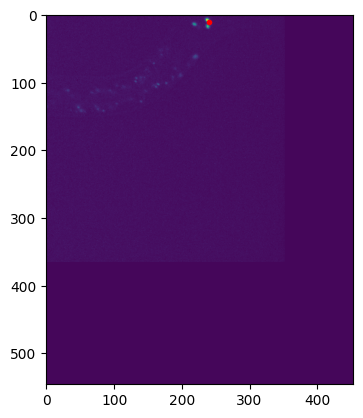

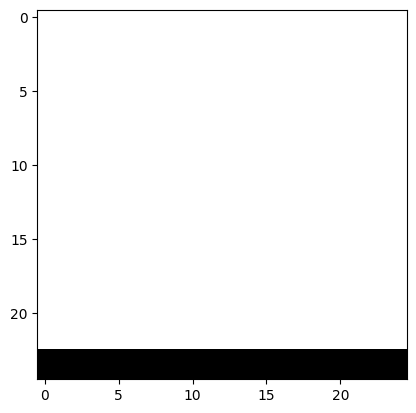

In [3]:

# PREPARE DATA FOR LSTM
# Train-test split
df_train_lst = []
df_test_lst=[]
video = "11410"

neuron_positions = positions_dct[video]
img_dir =rf"C:\Users\hozhang\Desktop\CaTracking\huayin_unet_lstm\images\original\{video}"
num_prev = 10
max_height=height
max_width=width

features_x = []
features_y = []
features_x_colorhist = []
features_x_mean= []
features_x_meanstd = []
PURPLE = (69, 6, 90)

# scale data (x or y position)
neuron_positions_x = [x for (x, y) in neuron_positions]
neuron_positions_y = [y for (x, y) in neuron_positions]
  
# since we need 10 previous frames as features, make sure we stop in time

for i in range(2515, 2515+1):
  frame = i+num_prev
  
  # Get features from image
  actx, acty = neuron_positions[frame]
  actx, acty = round(actx), round(acty)
  img_path = f"{img_dir}\{frame}.png"
  print(img_path)
  img= cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
  img = cv2.copyMakeBorder(img, 0, max_height-img.shape[0], 0, max_width-img.shape[1], borderType=cv2.BORDER_CONSTANT, value=PURPLE) # Add padding
  crop_size=12
  print(f"width: {img[0].shape} | height: {img.shape}")

  print(actx, acty, crop_size)
  print( actx-crop_size, actx+crop_size, acty-crop_size, acty+crop_size)
  print(img)

  cropped_img =  img[max(0, (acty)-crop_size):min(height, acty+crop_size+1), 
                    max(0, (actx)-crop_size):min(width, actx+crop_size+1), :]
  
  cropped_height, cropped_width = cropped_img.shape[:2]
  actual_crop_size = 2*crop_size+1
  
  if cropped_height != actual_crop_size:
    print(f"Height is {cropped_height} instead of {actual_crop_size}")
    for i in range(actual_crop_size-cropped_height):
      cropped_img = np.append(cropped_img, np.zeros((1, cropped_width, 3)), axis=0)
  if cropped_width != 2*crop_size+1:
    print(f"Width is {cropped_width} instead of {2*crop_size+1}")
  
  plt.imshow(img)
  plt.plot(actx, acty, 'ro', markersize=3)
  plt.figure()
  plt.imshow(cropped_img)
  print(cropped_img.shape)
  try:
    # Get visual features from cropped image (neuron)
    features_x_meanstd.append(np.concatenate(cv2.meanStdDev(cropped_img)).flatten()) # mean and std of each channel
    features_x_mean.append(cv2.mean(cropped_img)[:3]) # mean of each channel
    # features_x_colorhist.append(cv2.calcHist([cropped_img],[0,1,2],None,[8,8,8],[0,256,0,256,0,256]).flatten()) # color histogram
  except:
    print(f"Error with frame {frame}")
    print(f"Position : {actx}, {acty} | image dimension: {img.shape}")
    break
  
  # Get features from neuron positions
  features_x.append(neuron_positions_x[i:frame])
  features_y.append(neuron_positions_y[i:frame])
  
  i += 1

# Make dataframe with features and outcome variables
feature_dct = {'prev_n_x': features_x, 'curr_x': neuron_positions_x[num_prev:], 
        'prev_n_y': features_y, 'curr_y': neuron_positions_y[num_prev:], 
        'channel_means': features_x_mean, 'channel_means_std': features_x_meanstd
        } 



In [4]:
for key, value in feature_dct.items():
    print(key, len(value))


NameError: name 'feature_dct' is not defined

In [ ]:
df = pd.DataFrame(feature_dct)
df

,prev_n_x,curr_x,prev_n_y,curr_y,channel_means,channel_std
0,"[57.0, 58.428571428571445, 58.5, 57.0, 54.3999...",48.666667,"[466.0, 450.2857142857143, 434.0, 419.0, 403.2...",320.666667,"(96.56076388888889, 27.902777777777775, 71.972...","[96.56076388888889, 27.902777777777775, 71.972..."
1,"[58.428571428571445, 58.5, 57.0, 54.3999999999...",49.500000,"[450.2857142857143, 434.0, 419.0, 403.2, 389.8...",314.000000,"(96.82118055555556, 26.671875, 71.2517361111111)","[96.82118055555556, 26.671875, 71.251736111111..."
2,"[58.5, 57.0, 54.39999999999998, 51.60000000000...",50.500000,"[434.0, 419.0, 403.2, 389.8, 376.0, 362.5, 348...",312.000000,"(95.47743055555556, 26.230902777777775, 72.625)","[95.47743055555556, 26.230902777777775, 72.625..."
3,"[57.0, 54.39999999999998, 51.60000000000002, 4...",54.500000,"[419.0, 403.2, 389.8, 376.0, 362.5, 348.8, 333...",313.000000,"(99.41493055555556, 29.625, 68.84201388888889)","[99.41493055555556, 29.625, 68.84201388888889,..."
4,"[54.39999999999998, 51.60000000000002, 49.25, ...",50.500000,"[403.2, 389.8, 376.0, 362.5, 348.8, 333.8, 320...",326.000000,"(103.29513888888889, 37.53993055555555, 69.1875)","[103.29513888888889, 37.53993055555555, 69.187..."
5,"[51.60000000000002, 49.25, 47.5, 46.3999999999...",45.897521,"[389.8, 376.0, 362.5, 348.8, 333.8, 320.666666...",343.218957,"(104.21006944444444, 39.46527777777778, 69.651...","[104.21006944444444, 39.46527777777778, 69.651..."
6,"[49.25, 47.5, 46.39999999999998, 47.3999999999...",48.000000,"[376.0, 362.5, 348.8, 333.8, 320.6666666666667...",353.500000,"(101.83159722222221, 34.13368055555556, 69.046...","[101.83159722222221, 34.13368055555556, 69.046..."
7,"[47.5, 46.39999999999998, 47.39999999999998, 4...",48.333333,"[362.5, 348.8, 333.8, 320.6666666666667, 314.0...",366.333333,"(101.86458333333333, 33.61805555555556, 68.800...","[101.86458333333333, 33.61805555555556, 68.800..."
8,"[46.39999999999998, 47.39999999999998, 48.6666...",49.400000,"[348.8, 333.8, 320.6666666666667, 314.0, 312.0...",379.200000,"(104.30555555555554, 36.088541666666664, 69.10...","[104.30555555555554, 36.088541666666664, 69.10..."
9,"[47.39999999999998, 48.666666666666686, 49.5, ...",51.500000,"[333.8, 320.6666666666667, 314.0, 312.0, 313.0...",392.000000,"(104.63368055555554, 38.435763888888886, 69.14...","[104.63368055555554, 38.435763888888886, 69.14..."


In [ ]:
df.columns

Index(['prev_n_x', 'curr_x', 'prev_n_y', 'curr_y', 'channel_means',
       'channel_std'],
      dtype='object')

In [ ]:

# fragment to normalize
df_expanded = df.copy()
df_expanded
for col in ['prev_n_x', 'prev_n_y', 'channel_std', 'channel_means']:
    n = len(df_expanded[col][0])
    print(col, n)
    labels = [f"{col}_{i}" for i in range(n)]
    df_expanded[labels] = pd.DataFrame(df_expanded[col].tolist())
    df_expanded = df_expanded.drop(col, axis=1)
df_expanded

prev_n_x 10
prev_n_y 10
channel_std 6
channel_means 3


,curr_x,curr_y,prev_n_x_0,prev_n_x_1,prev_n_x_2,prev_n_x_3,prev_n_x_4,prev_n_x_5,prev_n_x_6,prev_n_x_7,...,prev_n_y_9,channel_std_0,channel_std_1,channel_std_2,channel_std_3,channel_std_4,channel_std_5,channel_means_0,channel_means_1,channel_means_2
0,48.666667,320.666667,57.000000,58.428571,58.500000,57.000000,54.400000,51.600000,49.250000,47.500000,...,333.800000,96.560764,27.902778,71.972222,17.444947,49.316624,26.342415,96.560764,27.902778,71.972222
1,49.500000,314.000000,58.428571,58.500000,57.000000,54.400000,51.600000,49.250000,47.500000,46.400000,...,320.666667,96.821181,26.671875,71.251736,16.680649,46.897994,23.374239,96.821181,26.671875,71.251736
2,50.500000,312.000000,58.500000,57.000000,54.400000,51.600000,49.250000,47.500000,46.400000,47.400000,...,314.000000,95.477431,26.230903,72.625000,17.432096,48.496318,28.644341,95.477431,26.230903,72.625000
3,54.500000,313.000000,57.000000,54.400000,51.600000,49.250000,47.500000,46.400000,47.400000,48.666667,...,312.000000,99.414931,29.625000,68.842014,16.546642,47.236679,15.993305,99.414931,29.625000,68.842014
4,50.500000,326.000000,54.400000,51.600000,49.250000,47.500000,46.400000,47.400000,48.666667,49.500000,...,313.000000,103.295139,37.539931,69.187500,16.875866,51.237144,17.796777,103.295139,37.539931,69.187500
5,45.897521,343.218957,51.600000,49.250000,47.500000,46.400000,47.400000,48.666667,49.500000,50.500000,...,326.000000,104.210069,39.465278,69.651042,17.460053,51.921704,19.849996,104.210069,39.465278,69.651042
6,48.000000,353.500000,49.250000,47.500000,46.400000,47.400000,48.666667,49.500000,50.500000,54.500000,...,343.218957,101.831597,34.133681,69.046875,17.438616,49.200919,17.203325,101.831597,34.133681,69.046875
7,48.333333,366.333333,47.500000,46.400000,47.400000,48.666667,49.500000,50.500000,54.500000,50.500000,...,353.500000,101.864583,33.618056,68.800347,17.684221,48.600447,19.096431,101.864583,33.618056,68.800347
8,49.400000,379.200000,46.400000,47.400000,48.666667,49.500000,50.500000,54.500000,50.500000,45.897521,...,366.333333,104.305556,36.088542,69.102431,16.860345,47.187284,18.137637,104.305556,36.088542,69.102431
9,51.500000,392.000000,47.400000,48.666667,49.500000,50.500000,54.500000,50.500000,45.897521,48.000000,...,379.200000,104.633681,38.435764,69.147569,17.328110,49.937420,18.791180,104.633681,38.435764,69.147569


In [ ]:
# Normalize features
scaler = MinMaxScaler()
df_norm = pd.DataFrame(scaler.fit_transform(df_expanded),
                  columns=df_expanded.columns)
df_norm

,curr_x,curr_y,prev_n_x_0,prev_n_x_1,prev_n_x_2,prev_n_x_3,prev_n_x_4,prev_n_x_5,prev_n_x_6,prev_n_x_7,...,prev_n_y_9,channel_std_0,channel_std_1,channel_std_2,channel_std_3,channel_std_4,channel_std_5,channel_means_0,channel_means_1,channel_means_2
0,0.321901,0.093694,0.876033,0.994097,1.000000,1.000000,0.987654,0.662888,0.389711,0.186281,...,0.272500,0.117847,0.126328,0.829324,0.789664,0.481443,0.818044,0.117847,0.126328,0.829324
1,0.418772,0.021622,0.994097,1.000000,0.876033,0.754717,0.641975,0.389711,0.186281,0.058411,...,0.108333,0.146176,0.033320,0.640944,0.117800,0.000000,0.583425,0.146176,0.033320,0.640944
2,0.535018,0.000000,1.000000,0.876033,0.661157,0.490566,0.351852,0.186281,0.058411,0.174657,...,0.025000,0.000000,0.000000,1.000000,0.778367,0.318156,1.000000,0.000000,0.000000,1.000000
3,1.000000,0.010811,0.876033,0.661157,0.429752,0.268868,0.135802,0.058411,0.174657,0.321901,...,0.000000,0.428329,0.256461,0.010894,0.000000,0.067417,0.000000,0.428329,0.256461,0.010894
4,0.535018,0.151351,0.661157,0.429752,0.235537,0.103774,0.000000,0.174657,0.321901,0.418772,...,0.012500,0.850425,0.854519,0.101226,0.289407,0.863734,0.142555,0.850425,0.854519,0.101226
5,0.000000,0.337502,0.429752,0.235537,0.090909,0.000000,0.123457,0.321901,0.418772,0.535018,...,0.175000,0.949953,1.000000,0.222424,0.802943,1.000000,0.304852,0.949953,1.000000,0.222424
6,0.244404,0.448649,0.235537,0.090909,0.000000,0.094340,0.279835,0.418772,0.535018,1.000000,...,0.390237,0.691218,0.597140,0.064458,0.784098,0.458411,0.095646,0.691218,0.597140,0.064458
7,0.283152,0.587387,0.090909,0.000000,0.082645,0.213836,0.382716,0.535018,1.000000,0.535018,...,0.518750,0.694806,0.558179,0.000000,1.000000,0.338884,0.245286,0.694806,0.558179,0.000000
8,0.407148,0.726486,0.000000,0.082645,0.187328,0.292453,0.506173,1.000000,0.535018,0.000000,...,0.679167,0.960340,0.744851,0.078983,0.275763,0.057585,0.169499,0.960340,0.744851,0.078983
9,0.651263,0.864865,0.082645,0.187328,0.256198,0.386792,1.000000,0.535018,0.000000,0.244404,...,0.840000,0.996034,0.922209,0.090785,0.686957,0.605016,0.221158,0.996034,0.922209,0.090785


In [ ]:
# Merge columns together again for training
columns = df.columns
columns = columns.drop(["curr_x", "curr_y"])
df_final = df.copy()
print(columns)
for col_name in columns:
    sub_cols = [col for col in df_norm.columns if col_name in col]
    print(col, sub_cols)
    df_final[col_name] = df_norm[sub_cols].values.tolist()
df_final[["curr_x", 'curr_y']] = df_norm[["curr_x", 'curr_y']]
df_final


Index(['prev_n_x', 'prev_n_y', 'channel_means', 'channel_std'], dtype='object')
channel_means ['prev_n_x_0', 'prev_n_x_1', 'prev_n_x_2', 'prev_n_x_3', 'prev_n_x_4', 'prev_n_x_5', 'prev_n_x_6', 'prev_n_x_7', 'prev_n_x_8', 'prev_n_x_9']
channel_means ['prev_n_y_0', 'prev_n_y_1', 'prev_n_y_2', 'prev_n_y_3', 'prev_n_y_4', 'prev_n_y_5', 'prev_n_y_6', 'prev_n_y_7', 'prev_n_y_8', 'prev_n_y_9']
channel_means ['channel_means_0', 'channel_means_1', 'channel_means_2']
channel_means ['channel_std_0', 'channel_std_1', 'channel_std_2', 'channel_std_3', 'channel_std_4', 'channel_std_5']


,prev_n_x,curr_x,prev_n_y,curr_y,channel_means,channel_std
0,"[0.8760330578512403, 0.9940968122786322, 0.999...",0.321901,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.92944785...",0.093694,"[0.11784702549575066, 0.12632821723730814, 0.8...","[0.11784702549575066, 0.12632821723730814, 0.8..."
1,"[0.9940968122786322, 0.9999999999999996, 0.876...",0.418772,"[0.8918741808650066, 0.8805031446540879, 0.877...",0.021622,"[0.14617563739376926, 0.03332021513839711, 0.6...","[0.14617563739376926, 0.03332021513839711, 0.6..."
2,"[0.9999999999999996, 0.8760330578512403, 0.661...",0.535018,"[0.7798165137614679, 0.7704402515723268, 0.747...",0.000000,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0, 0.7783669553102008, 0.31815608..."
3,"[0.8760330578512403, 0.6611570247933876, 0.429...",1.000000,"[0.676605504587156, 0.6545073375262054, 0.6377...",0.010811,"[0.4283286118980172, 0.25646071100616563, 0.01...","[0.4283286118980172, 0.25646071100616563, 0.01..."
4,"[0.6611570247933876, 0.42975206611570504, 0.23...",0.535018,"[0.5678899082568809, 0.5561844863731658, 0.524...",0.151351,"[0.8504249291784713, 0.8545192181555814, 0.101...","[0.8504249291784713, 0.8545192181555814, 0.101..."
5,"[0.42975206611570504, 0.23553719008264595, 0.0...",0.000000,"[0.4756880733944957, 0.4549266247379453, 0.413...",0.337502,"[0.9499527856468379, 1.0, 0.22242396731729386]","[0.9499527856468379, 1.0, 0.22242396731729386,..."
6,"[0.23553719008264595, 0.0909090909090926, 0.0,...",0.244404,"[0.3807339449541285, 0.3558700209643604, 0.301...",0.448649,"[0.6912181303116149, 0.59714023350387, 0.06445...","[0.6912181303116149, 0.59714023350387, 0.06445..."
7,"[0.0909090909090926, 0.0, 0.08264462809917328,...",0.283152,"[0.2878440366972477, 0.25534591194968526, 0.17...",0.587387,"[0.6948064211520304, 0.5581791945428312, 0.0]","[0.6948064211520304, 0.5581791945428312, 0.0, ..."
8,"[0.0, 0.08264462809917328, 0.18732782369146284...",0.407148,"[0.19357798165137607, 0.1452830188679246, 0.07...",0.726486,"[0.9603399433427757, 0.744851108487472, 0.0789...","[0.9603399433427757, 0.744851108487472, 0.0789..."
9,"[0.08264462809917328, 0.18732782369146284, 0.2...",0.651263,"[0.09036697247706416, 0.04891684136967145, 0.0...",0.864865,"[0.9960339943342778, 0.9222091040272855, 0.090...","[0.9960339943342778, 0.9222091040272855, 0.090..."


In [ ]:
df['curr_frame']= [j for j in range(num_prev, len(neuron_positions))]

In [ ]:
df, scaler

In [ ]:
split = math.floor(len(video_df)*0.8)
df_train_lst.append(video_df[:split]) # Get features and outcome variables for each video
df_test_lst.append(video_df[split:]) # Get features and outcome variables for each video

df_train = pd.concat(df_train_lst)
df_test = pd.concat(df_test_lst)

x_train = np.array(df_train.prev_n_x.tolist())
x_test = np.array(df_test.prev_n_x.tolist())
y_train = np.array(df_train.curr_x.tolist())
y_test = np.array(df_test.curr_x.tolist())

x_train2 = np.array(df_train.prev_n_y.tolist())
x_test2 = np.array(df_test.prev_n_y.tolist())
y_train2 = np.array(df_train.curr_y.tolist())
y_test2 = np.array(df_test.curr_y.tolist())
print("Finished test-train split")
# Create dataset and dataloader
train_set = CaImagesDataset(x_train,y_train)
train_loader = DataLoader(train_set,
                          shuffle=True,
                          batch_size=256 # Each batch has 256 samples. (e.g. if dataset has 2048 samples total, there are 8 training batches)
                          )

train_set2 = CaImagesDataset(x_train2,y_train2)
train_loader2 = DataLoader(train_set2,
                          shuffle=True,
                          batch_size=256 # Each batch has 256 samples. (e.g. if dataset has 2048 samples total, there are 8 training batches)
                          )
test_set = CaImagesDataset(x_test,y_test)
test_set2 = CaImagesDataset(x_test2,y_test2)
print("Finished creating dataset and dataloader")


# TRAIN MODEL
train = False # True if training x model, False if loading model
load=False
load_num = 2 # for saving/loading model x
save_num = 1

train2 = True # True if training y model, False if loading model
load2=False
load_num2 = 3 # for saving/loading model y
save_num2=4
# Get X model
if train:
  # Create model
  model = neural_network()

  # Optimizer and loss function 
  criterion = torch.nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)

  # Training loop
  epochs = 500
  existing_epochs=0
  train_times = {} #key= epoch, value=loss for that epoch
  for i in range(epochs+1):
      for j,data in enumerate(train_loader):
          y_pred = model(data[:][0].view(-1,10,1)).reshape(-1)
          loss = criterion(y_pred,data[:][1])
          loss.backward()
          optimizer.step()
      existing_epochs+=1
      train_times[existing_epochs] = loss
      if i%50 == 0:
          print(existing_epochs,"th iteration : ",loss)
  joblib.dump(model, f'model{save_num}.pkl')
  print(f"saved x model {save_num}")

    # Plot loss curve
  losses = [tsr.detach().numpy().flat[0] for tsr in train_times.values()]
  plt.figure()
  plt.plot(train_times.keys(), losses)
  plt.title("Train Loss Curve")
  plt.show()
else:
  model = joblib.load(f'model{load_num}.pkl')
  print("loaded x model")

# Get Y model
if train2:
  # Create model
  if load2:
     model2=joblib.load(f'ymodel{load_num2}.pkl')
  else:
    model2 = neural_network()

  # Optimizer and loss function 
  criterion2 = torch.nn.MSELoss()
  optimizer2 = torch.optim.Adam(model2.parameters(),lr=0.0001)

  # Training loop
  epochs2 = 500
  existing_epochs2=0
  train_times2 = {} #key= epoch, value=loss for that epoch
  for i in range(epochs2+1):
      for j,data in enumerate(train_loader2):
          y_pred = model2(data[:][0].view(-1,10,1)).reshape(-1)
          loss2 = criterion2(y_pred,data[:][1])
          loss2.backward()
          optimizer2.step()
      existing_epochs2+=1
      train_times2[existing_epochs2] = loss2
      if i%50 == 0:
          print(existing_epochs2,"th iteration : ", loss2)
  joblib.dump(model2, f'ymodel{save_num2}.pkl')
  print(f"saved y model {save_num2}")

  # Plot loss curve
  losses2 = [tsr.detach().numpy().flat[0] for tsr in train_times2.values()]
  plt.figure()
  plt.plot(train_times2.keys(), losses2)
  plt.title("Train Loss Curve")
  plt.show()
else:
  model2 = joblib.load(f'ymodel{load_num2}.pkl')
  print("loaded y model")


# Visualize

In [ ]:

# VISUALIZE PREDICTIONS
# Plot x coordinates actual vs predicted
fig, ax = plt.subplots(1,2)
train_pred = model(train_set[:][0].view(-1,10,1)).view(-1)
test_pred = model(test_set[:][0].view(-1,10,1)).view(-1)

ax[0].plot(train_pred.detach().numpy(),label='predicted')
ax[0].plot(train_set[:][1].view(-1),label='original')
ax[0].title.set_text("Training Set Actual vs Predicted (X Coordinates)")
ax[0].legend()

ax[1].plot(test_pred.detach().numpy(),label='predicted')
ax[1].plot(test_set[:][1].view(-1),label='original')
ax[1].title.set_text("Test Set Actual vs Predicted (X Coordinates)")

ax[0].set_xlabel("Frame")
ax[0].set_ylabel("X Coordinates")
ax[1].set_xlabel("Frame")
ax[1].legend()
plt.show()

# Plot y coordinates actual vs predicted
fig2, ax2 = plt.subplots(1,2)
train_pred2 = model(train_set2[:][0].view(-1,10,1)).view(-1)
test_pred2 = model(test_set2[:][0].view(-1,10,1)).view(-1)

ax2[0].plot(train_pred2.detach().numpy(),label='predicted')
ax2[0].plot(train_set2[:][1].view(-1),label='original')
ax2[0].title.set_text("Training Set Actual vs Predicted (Y Coordinates)")
ax2[0].legend()

ax2[1].plot(test_pred2.detach().numpy(),label='predicted')
ax2[1].plot(test_set2[:][1].view(-1),label='original')
ax2[1].title.set_text("Test Set Actual vs Predicted (Y Coordinates)")
ax2[0].set_xlabel("Frame")
ax2[0].set_ylabel("Y Coordinates")
ax2[1].set_xlabel("Frame")
ax2[1].legend()
plt.show()

# Plot x and y coordinates
fig3, ax3 = plt.subplots(1,2)
ax3[0].plot(train_pred.detach().numpy(), train_pred2.detach().numpy(),label='predicted')
ax3[0].plot(train_set[:][1].view(-1), train_set2[:][1].view(-1),label='original')
ax3[1].plot(test_pred.detach().numpy(), test_pred2.detach().numpy(),label='predicted')
ax3[1].plot(test_set[:][1].view(-1), test_set2[:][1].view(-1),label='original')
ax3[0].title.set_text("Training Set Path of Neuron (X and Y Coordinates)")
ax3[1].title.set_text("Test Set Path of Neuron (X and Y Coordinates)")
ax3[0].set_xlabel("X Coordinates")
ax3[0].set_ylabel("Y Coordinates")
ax3[1].set_xlabel("X Coordinates")
ax3[0].legend()
ax3[1].legend()
plt.show()

# EVALUATE MODEL
# RMSE
print("X coordinates")
print(f"Train RMSE: {np.sqrt(mean_squared_error(train_pred.view(-1).detach().numpy(), train_set[:][1].view(-1).detach().numpy()))}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(test_pred.view(-1).detach().numpy(), test_set[:][1].view(-1).detach().numpy()))}")
# print(f"Train R^2: { model_selection.cross_val_score(model, train_set[:][0].view(-1,10,1), train_set[:][1].view(-1), cv=5).mean() }")
# print(f"Test R^2: { model_selection.cross_val_score(model, test_set[:][0].view(-1,10,1), test_set[:][1].view(-1), cv=5).mean() }")

print("Y coordinates")
print(f"Train RMSE: {np.sqrt(mean_squared_error(train_pred2.view(-1).detach().numpy(), train_set2[:][1].view(-1).detach().numpy()))}")
print(f"Train RMSE: {np.sqrt(mean_squared_error(test_pred2.view(-1).detach().numpy(), test_set2[:][1].view(-1).detach().numpy()))}")